In [1]:
!apt update
!apt install python-opengl xvfb -y
!pip install gym[box2d]==0.18.3 pyvirtualdisplay tqdm numpy==1.19.5 torch==1.8.1

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:13 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu180

In [2]:
%%capture
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

%matplotlib inline
import matplotlib.pyplot as plt

from IPython import display

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm.notebook import tqdm

In [3]:
seed = 543 # Do not change this
def fix(env, seed):
  env.seed(seed)
  env.action_space.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)
  random.seed(seed)
  torch.set_deterministic(True)###########################################
  torch.use_deterministic_algorithms(False)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

In [4]:
!sudo apt-get install build-essential python-dev swig python-pygame

!pip install Box2D

Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.4ubuntu1).
python-dev is already the newest version (2.7.15~rc1-1).
The following additional packages will be installed:
  fonts-freefont-ttf libfluidsynth1 libmad0 libmikmod3 libportmidi0
  libsdl-image1.2 libsdl-mixer1.2 libsdl-ttf2.0-0 libsdl1.2debian libsmpeg0
  swig3.0 timgm6mb-soundfont
Suggested packages:
  timidity swig-doc swig-examples swig3.0-examples swig3.0-doc
  fluid-soundfont-gm fluidsynth musescore
The following NEW packages will be installed:
  fonts-freefont-ttf libfluidsynth1 libmad0 libmikmod3 libportmidi0
  libsdl-image1.2 libsdl-mixer1.2 libsdl-ttf2.0-0 libsdl1.2debian libsmpeg0
  python-pygame swig swig3.0 timgm6mb-soundfont
0 upgraded, 14 newly installed, 0 to remove and 70 not upgraded.
Need to get 13.1 MB of archives.
After this operation, 31.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.co

In [5]:
%%capture
import gym
import random
import numpy as np

env = gym.make('LunarLander-v2')

fix(env, seed)

In [6]:
!pip freeze

absl-py==0.12.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.1.0
appdirs==1.4.4
argon2-cffi==20.1.0
arviz==0.11.2
astor==0.8.1
astropy==4.2.1
astunparse==1.6.3
async-generator==1.10
atari-py==0.2.9
atomicwrites==1.4.0
attrs==21.2.0
audioread==2.1.9
autograd==1.3
Babel==2.9.1
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==3.3.0
blis==0.4.1
bokeh==2.3.2
Bottleneck==1.3.2
Box2D==2.3.10
box2d-py==2.3.8
branca==0.4.2
bs4==0.0.1
CacheControl==0.12.6
cached-property==1.5.2
cachetools==4.2.2
catalogue==1.0.0
certifi==2021.5.30
cffi==1.14.5
cftime==1.5.0
chardet==3.0.4
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorcet==2.0.6
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.3.2
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cvxopt==1.2.6
cvxpy==1.0.31
cycler==0.10.0
cymem==2.0.5
Cython==0.29.23
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.1
descartes==1.1.0
dill==0.3.4
distributed==1.25

In [7]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [8]:
from collections import namedtuple, deque

BUFFER_SIZE = int(1e5)  
BATCH_SIZE = 64  
GAMMA = 0.99  
TAU = 1e-3  
LR = 5e-4  
UPDATE_EVERY = 4  

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class Agent():

    def __init__(self, state_size, action_size, seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)

        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:

            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences

        q_hat = self.qnetwork_target.forward(next_states).detach().max(dim=1)[0].unsqueeze(1)
        target = rewards + gamma * q_hat * (1 - dones)
        q_local = self.qnetwork_local.forward(states).gather(1, actions)
        loss = F.mse_loss(q_local, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

    def soft_update(self, local_model, target_model, tau): 
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)


class ReplayBuffer:

    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

Episode 100	Average Score: -150.48
Episode 200	Average Score: -116.56
Episode 300	Average Score: -75.43
Episode 400	Average Score: -26.86
Episode 500	Average Score: 51.32
Episode 600	Average Score: 148.96
Episode 700	Average Score: 208.37
Episode 800	Average Score: 241.18
Episode 900	Average Score: 238.05
Episode 1000	Average Score: 215.85
Episode 1100	Average Score: 229.05
Episode 1200	Average Score: 237.39
Episode 1300	Average Score: 234.78
Episode 1400	Average Score: 253.49
Episode 1500	Average Score: 245.44
Episode 1600	Average Score: 247.64
Episode 1700	Average Score: 259.93
Episode 1800	Average Score: 262.71
Episode 1900	Average Score: 261.54
Episode 2000	Average Score: 261.18


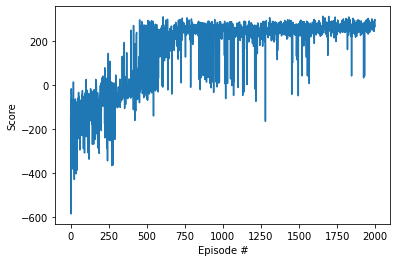

In [9]:

agent = Agent(state_size=8, action_size=4, seed=4)

def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
  scores = [] 
  scores_window = deque(maxlen=100) 
  eps = eps_start  
  for i_episode in range(1, n_episodes + 1):
      state = env.reset()
      score = 0
      for t in range(max_t):
          action = agent.act(state, eps)
          next_state, reward, done, _ = env.step(action)
          agent.step(state, action, reward, next_state, done)  
          state = next_state
          score += reward
          if done:
              break
      scores_window.append(score)  
      scores.append(score) 
      eps = max(eps_end, eps_decay * eps)  
      print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
      if i_episode % 100 == 0:
          print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
      # if np.mean(scores_window) >= 200.0:
      #     print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode - 100, np.mean(scores_window)))
      #     torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
      #     break
  return scores


scores = dqn()


fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

/usr/local/lib/python3.7/dist-packages/torch/__init__.py:422: UserWarning: torch.set_deterministic is deprecated and will be removed in a future release. Please use torch.use_deterministic_algorithms instead
  "torch.set_deterministic is deprecated and will be removed in a future "


263.8016506085589
length of actions is  278
272.44112066094755
length of actions is  239
247.63996325519966
length of actions is  243
241.90261682023728
length of actions is  210
286.2632268425573
length of actions is  232


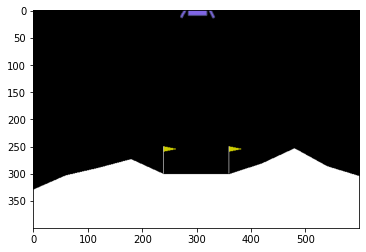

In [10]:
fix(env, seed)
NUM_OF_TEST = 5 # Do not revise it !!!!!
test_total_reward = []
action_list = []
for i in range(NUM_OF_TEST):
  actions = []
  state = env.reset()

  img = plt.imshow(env.render(mode='rgb_array'))

  total_reward = 0

  done = False
  while not done:
      action = agent.act(state)
      actions.append(action)
      state, reward, done, _ = env.step(action)

      total_reward += reward

      # img.set_data(env.render(mode='rgb_array'))
      # display.display(plt.gcf())
      # display.clear_output(wait=True)
  print(total_reward)
  test_total_reward.append(total_reward)

  action_list.append(actions) #儲存你測試的結果
  print("length of actions is ", len(actions))

In [17]:
print(f"Your final reward is : %.2f"%np.mean(test_total_reward))

Your final reward is : 262.41


In [12]:
print("Action list looks like ", action_list)
print("Action list's shape looks like ", np.shape(action_list))

Action list looks like  [[1, 1, 1, 1, 1, 3, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 1, 3, 2, 2, 2, 3, 1, 2, 2, 2, 2, 2, 2, 2, 1, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 1, 2, 2, 2, 2, 3, 1, 3, 2, 2, 1, 2, 3, 2, 2, 2, 1, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 0, 2, 0, 2, 0, 2, 3, 2, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 2, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 2, 2, 2, 0, 2, 0, 2, 0, 3, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 2, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 1, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [3, 3, 3, 0, 3, 0, 0, 0, 0, 0, 3, 0, 3, 1, 3, 3, 3, 1, 1, 3, 1, 3, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 0, 2, 2, 0, 2, 0, 2, 

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [13]:
distribution = {}
for actions in action_list:
  for action in actions:
    if action not in distribution.keys():
      distribution[action] = 1
    else:
      distribution[action] += 1
print(distribution)

{1: 177, 3: 175, 2: 526, 0: 324}


In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
PATH = "/content/drive/MyDrive/hw12/Action_List_test.npy" # 可以改成你想取的名字或路徑
np.save(PATH ,np.array(action_list)) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [16]:
from google.colab import files
files.download(PATH)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>